<a href="https://colab.research.google.com/github/lejimmy/handson-ml-workbooks/blob/master/04_training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4. Training Models

So far, we have trained algorithsm mostly like black boxes.  We were able to optimize a regression system, improve a digit image classifier, and even built a spam classifier from scratch.

However, having a good understanding of how things work underneath can help you quickly hone in on the appropriate model, the right training algorithm to use, and a good set of hyperparemeters for the task.

Also, understanding what's under the hood can help you debug issues and perform error analysis more efficiently.

In this chapter, we will look at the Linear Regression model and the two ways to train it:
- A direct "closed form" equation that directly computes the model parameters that best fit the model
- An iterative optimization approach, called gradient descent (GD) that tweaks the parameters to minimize the cost function over the training set.

We will also look at polynomial regression, logistic regression, and softmax regression.

# Linear Regression

In general, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term*.

$\hat{y} = \theta_1 + \theta_2x_1 + \theta_2x_2 + ... + \theta_nx_n$

In this equation:
- $\hat{y}$ is the predicted value
- *n* is the number of features
- $x_i$ is the $i^{th}$ feature value
- $\theta_j$ is the $j^{th}$ model parameter (including the bias term $\theta_0$ and the feature weights)

This can be written much more concisely using a vectorized form:

$\hat{y} = h_\theta(x) = \theta \cdot x$

In this equation:
- __$\theta$__ is the model's *parameter vector*, containing the bias term $\theta_0$ and the feature weights $\theta_1$ to $\theta_n$
- __x__ is the instance's *feature vector*, containing $x_0$ to $x_n$, with $x_0$ always equal to 1.
- $\theta \cdot x$ is the dot product of the vectors __$\theta$__ and __x__, which is of course qual to $\theta_1 + \theta_2x_1 + \theta_2x_2 + ... + \theta_nx_n$.
- $h_\theta$ is the hypothesis function, using the model parameters $\theta$

To train a Linear Regression model, you need to find values of $\theta$ that minimizes the Root Mean Square Error (RMSE).

The MSE of a Linear Regression hypothesis $h_\theta$ on a training set __X__ is calculated by:

$MSE(X, h_\theta) = \frac{1}{m} \sum_{i=1}^{m}(\theta^Tx^i - y^i)^2$

## The Normal Equation

To find the value of $\theta$ that minimizes the cost function, there is a *closed-form solution* that gives us the result directly.

$\hat{\theta} = (X^T X)^{-1} X^T y$

In this equation:
- $\hat{\theta}$ is the value of $\theta$ that minimzes the cost function
- __y__ is the vector of target values containing $y^1$ to $y^m$

Let's generate some linear-looking data to test this equation:

In [0]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

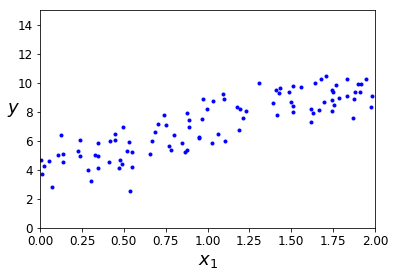

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

Now let's compute $\hat{\theta}$ using the Normal Equation.

We will use the `inv()` function from NumPy's Lienar Algebra module (`np.linalg`) to compute the inverse of a matrix and the `dot()` method for matrix multiplication.

In [0]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.13646939],
       [2.91333205]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 3.83$ and $\theta_1 = 3.13$.  We are close enough but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using $\hat{\theta}$.

In [0]:
# array of X values
X_new = np.array([[0], [2]])
X_new

array([[0],
       [2]])

In [0]:
# add column of 1
X_new_b = np.c_[np.ones((2, 1)), X_new]
X_new_b

array([[1., 0.],
       [1., 2.]])

In [0]:
# use theta best to predict y values
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.13646939],
       [9.96313348]])

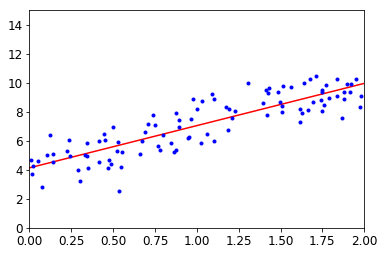

In [0]:
# plot models prediction
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

Now, let's use Scikit-Learn to perform linear regression:

In [0]:
from sklearn.linear_model import LinearRegression

# Linear Regression constructor
lin_reg = LinearRegression()

# fit the data
lin_reg.fit(X, y)

# intercept and coefficient attributes
lin_reg.intercept_, lin_reg.coef_

(array([4.13646939]), array([[2.91333205]]))

In [0]:
# use model to predict new y values
lin_reg.predict(X_new)

array([[4.13646939],
       [9.96313348]])

We get the same answers as before!

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` "least squares" function which we can call directly:

In [0]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[4.13646939],
       [2.91333205]])

This function computes $\hat{\theta} = X^+ y$ where $X^+$ is the *psuedoinverse* of X (specifically the Moore-Penrose inverse).  We can use `np.linalg.pinv()` to compute the psuedoinverse directly:

In [0]:
# psuedoinverse
np.linalg.pinv(X_b).dot(y)

array([[4.13646939],
       [2.91333205]])

In some instances, the Normal Equation may not work if $X^TX$ is not invertible.  This means that the equations are not linearly independent.

However, the pseudoinverse is always defined.  This approach is more efficient than computing the Normal Equation.

## Computational Complexity

The Normal Equation computes the inverse of $X^TX$ which is an (*n*+1) x (*n*+1) matrix (where *n* is the number of features).

The *computational complexity* of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation.

In other words, if you double the amount of features, you increase the computational time by 5.3 to 8 times.

The *Singular Value Decomposition* (SVD) approach which uses the pseudoinverse in Scikit-Learn's `LinearRegression` class has a computational complexity of $O(n^2)*.  So if you double the number of features, you multiply the computational time by 4.

__Warning: Both the Normal Equation and SVD appraoch get very slow when the number of features grow large (e.g. 100,000).  However, both are still linear with regard to the number of instances in the training set, so they can handle large training sets efficiently.__

Now we will look at different ways to train a Linear Regression model which is better suited for cases where there are a large number of features or too many training instances to fit in memory.

# Gradient Descent

*Gradient Descent* is a generic optimization algorithm capable of finding optimal solutions to awide range of problems.  The general idea is to tweak parameters iteratively in order to minimize a cost function.

It measures the local gradient of the error function with regard to the parameter vector $\theta$ and goes in the direction of descending gradient.  Once the gradient is zero, you've reached a minimum!

You start by filling in random values of $\theta$ and improve it gradually by attempting to decrease the cost function until you converge to a minimum.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0403.png)

An important parameter is the *learing rate* hyperparameter.  If the learning rate is too small, the algorithm will have to go through many iterations to converge.

If the learning rate is too high, you might jump across the valley and end up causing divergence and never converging.

Two challenges of Gradient Descent are irregular terrains that make convergence to the Global minimum difficult:

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0406.png)

For a Linear Regression model, the MSE cost function is a *convex function*, which means if you pick any two points on the curve, the line segment joining them never crosses the curve.  Also, it is a continuous function where the slope does not change abrupty.  

These two facts means that Gradient Descent is guaranteed to approach the global minimum (if you wait long enough and if the learning rate is not too high).

When the features have the same scale, the Gradient Descent algorithm goes straight towards the minimum.

When feature 1 has much smaller values than feature 2, the Gradient Descent algorithm moves orthogonal to the global minimum and ends with a long march down an almost flat valley.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0407.png)

__Warning: When using Gradient Descent, you should ensure all features have a similar scale by using Scikit-Learn's `StandarScaler` class, else it will take much longer to converge.__

## Batch Gradient Descent

To implement Gradient Descent, we will compute the gradient of the cost function with regard to each model parameter $\theta_j$.

We will need to calculate how much the cost function will change if we change $\theta_j$ just a little bit.

We compute the partial derivative of the cost function with regard to parameter $\theta_j$, noted $\frac{\delta}{\delta\theta_j}MSE(\theta)$.

Instead of computing the partial derivatives for each feature individually, we can compute them all in one go using the gradient vector $\triangledown MSE(\theta)$, which contains all the partial derivatives of the cost function.

$\triangledown_\theta MSE(\theta) = \begin{pmatrix} \frac{\delta}{\delta\theta_0}MSE(\theta) \\ \frac{\delta}{\delta\theta_1}MSE(\theta) \\ \vdots \\ \frac{\delta}{\delta\theta_n}MSE(\theta)\end{pmatrix}= \frac{2}{m} X^T (X \theta - y)$ 

Where:
- m = number of training examples

__Warning: The formula involves calculations over the full training set X, at each Gradient Descent step.  As a result, it is terribly slow on very large training sets.  However, training a Linear Regression model with hundreds of thousdands of features is much fater using Gradient descent vs. the Normal Equation or SVD decomposition.__

Once you have the gradient vector, which points uphill, go in the opposite direction to go downhill.  The learning rate $\eta$ is multiplied by the gradient vector to determine the size of the downhill step.

$\theta^{(next step)} = \theta - \eta \triangledown_\theta MSE(\theta)$

Let's implement this algorithm:

In [0]:
# learning rate
eta = 0.1

# number of iterations
n_iterations = 1000

# number of training examples
m = 100

# random initialization
theta = np.random.randn(2, 1)

# gradient descent
for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [0]:
theta

array([[4.13646939],
       [2.91333205]])

Perfect this is exactly what the Normal Equation found!  Gradient Descent worked perfectly.

If we had different learning rates of `eta` here is what would have happened in the first 10 steps:

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0408.png)

On the left, the learning rate is too low.  It will reach the solution but it will take a long time.  On the right, the learning rate is too high, the algorithm diverges further and further away from the solution.

To find a good learning rate, you can use grid search from Chapter 2.

To find a good number of iterations, set a very large number of iterations but interrupt the algorithm when the gradient vector becomes tiny - when its norm becomes smaller than a tiny number $\epsilon$ (called the *tolerance*).  This happens when Gradient Descent has almost reached the minimum.

## Stochastic Gradient Descent

The main problem with Batch Gradient Descent is that it used the whole training set to compute the gradients at each step, which can be very slow when the training set is large.

At the other extreme, *Stochastic Gradient Descent* picks a random instnace in the training set at every step and computes the gradients based on that single instance.  This is much faster since it only has a single instance to compute.

However, since it is random, the cost function bounces up and down, decreasing only on average.  Over time it will end up very close to the minimum but never converge.  The final parameter values are good, but not optimal.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0409.png)

When the cost function is irregular, it can help the algorithm jump out of local mimima and have a better chance of finding the global minimum.

One way to deal with the algorithm never settling is to gradually reduce the learning rate.  This is similar to *simulated annealing* where molten metal is slowly cooled down.

The function that determines the learning rate at each iteration is called the *learning schedule*.

Let's implement the Stochastic Gradient Descent using a simple learning schedule:

In [0]:
# epoch: rounds of m iterations
n_epochs = 50

# learning schedule hyperparameters
t0, t1 = 5, 50

# learning schedule
def learning_schedule(t):
  return t0 / (t + t1)

# random initialization
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
  for i in range(m):

    # random instance from training data
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    
    # compute gradients
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)

    # simulated annealing
    eta = learning_schedule(epoch * m + i)

    # next step
    theta = theta - eta * gradients

In [0]:
theta

array([[4.12378229],
       [2.95044012]])

While the Batch Gradient Descent code iterated 1,000 times through the whole training set, this code only goes through the training set 50 times and reached a pretty good solution.

Because the instances are picked at random, some instances may be picked several times, while others are not picked at all.

To ensure the algorithm uses every instance, we can shuffle the training set and go through each instance, shuffle the set, etc.  However, this approach will converge more slowly.

To perform Linear Regressing using SGD with Scikit-Learn, we will use the `SGDRegressor` class.

The following code runs for 1,000 epochs or until the loss drops to less than 0.001 during one epoch. (`max_iter = 1000, tol = 1e-3).  It starts with a learning rate of 0.1 (`eta0 = 0.1`), using the default learning schedule.

In [0]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.06922972]), array([2.85800728]))

Again, we find a solution quite close to the one returned from the Normal Equation.

## Mini-batch Gradient Descent

Instead of computing the gradient on the entire training set or a random instance, *Mini-batch Gradient Descent* computes the gradients on small random sets of instances called *mini-batches*.  The main advantage of using Mini-batch over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations when using GPUs.

This algorithm is less erratic than SGD, so it will end up a bit closer to the minimum than SGD.  However, it may be harder to escape local minima.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0411.png)

Summary of our algorithms for Linear Regression so far:

$\begin{array}{lllllll}
Algorithm       & Large m & Out-of-core support & Large n & Hyperparams     & Scaling required & Scikit-Learn     \\
Normal Equation & Fast    & No                  & Slow    & 0               & No               & n/a              \\
SVD             & Fast    & No                  & Slow    & 0               & No               & LinearRegression \\
Batch GD        & Slow    & No                  & Fast    & 2               & Yes              & SGDRegressor     \\
Stochastic GD   & Fast    & Yes                 & Fast    & >2 & Yes              & SGDRegressor     \\
Mini-batch GD   & Fast    & Yes                 & Fast    & >2 & Yes              & SGDRegressor    
\end{array}$

__Note: After training, there is almost no difference.  All algorithms have ended up with very similar models and make predictions in exactly the same way.__

# Polynomial Regression

What if the data is more complex than a straight line?  We can still use a linear model to fit nonlinear data.

One way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features.  This is called *Polynomial Regression*.

Let's look at a a simple *quadratic equation* plus some noise:

In [0]:
import numpy.random as rnd
np.random.seed(42)

# number of training points
m = 100

# random numbers between -3 and 3
X = 6 * np.random.rand(m, 1) - 3

# y = 0.5 x^2 + x + 2 + noise
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

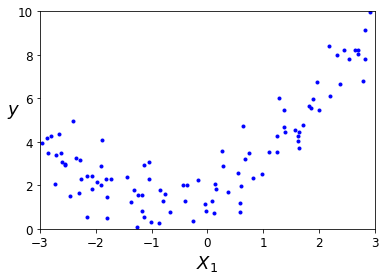

In [0]:
plt.plot(X, y, 'b.')
plt.xlabel('$X_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.axis([-3, 3, 0, 10])
plt.show()

We can use Scikit-Learn's `PolynomialFeatures` class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as new features:

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [0]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original features of X plus the square of this feature.  Now you can fit a `LinearRegression` model to this extended training data:

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Not bad!  The model estimates $\hat{y} = 0.50x^2_1 + 1.02x_1 + 1.96$ when the original function was $y = 0.50x^2_1 + 1.0x_1 + 2.0$ + Gaussian noise.

Polynomial Regression is capable of finding relationships between features.  `PolynomialFeatures` also adds combinations of features up to the given degree.  For example, if thhere were two features $a$ and $b$, `PolynomialFeatures` with `degree=3` would not only add the features of $a^2$, $a^3$, $b^2$, and $b^3$, but also combinations $ab$, $a^2b$, and $ab^2$.

__Warning: `PolynomialFeatures(degree = d)` transforms an array containing *n* features into an array containing $\frac{(n + d)!}{d!n!}$ features.  Beware of the explosion of number of features!__

# Learning Curves

High-degree Polynomial Regression will likely fit the training data much better than plain Linear Regression.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0414.png)

In the above figure, the Polynomial Regression is severely overfitting the data, while the linear model is underfitting it.

In general, you won't know what function generated the data, so how can you decide how complex the model should be?

In Ch 2, we used cross-validation to estimate a model's generalization performance.  If it performs well on the training data but poorly on the cross-validation metrics, then your model is overfitting.  If it performs poorly on both, then it is underfitting.

Another way is to look at the *learning curves*: these are plots of the model's performance on the training set and the validation set as a function of the training set size (or the training iteration).



In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []

    # train model as amount of training data increases
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)

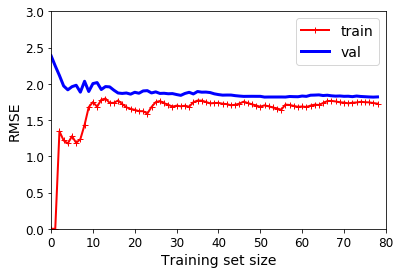

In [0]:
# define Lienar Regression model
lin_reg = LinearRegression()

# plot learning curves
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

When there are only two points, the model can fit the training set perfectly - but has a really high error for the validation set.  As the model sees more and more data, the error plateaus as a linear model would never be able to fit a quadratic equation.

This is a curve typical of a model that is underfitting.  Both curves have plateaued, they are close and the error is high.

__Tip: If the model is underfitting, more data will not help.  We would need to use a more complex model or come up with better features.__

Now, let's look at the learning curve of a 10th degree polynomial model on the same data:

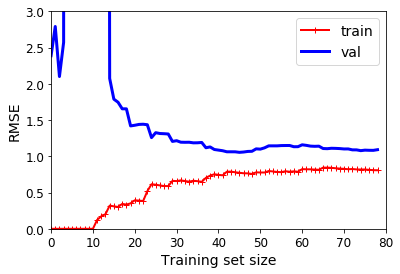

In [0]:
from sklearn.pipeline import Pipeline

# create 10 degree features
polynomial_regression = Pipeline([
        ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)),
        ('lin_reg', LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

There are two importance differences here:
- The error in the training data is much lower
- If there is a gap between the curves, meaning the model does better on the training data than the validation error, which is a hallmark of an overfitting model.

__Tip: One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.__

### The Bias/Variance Trade-Off

- *Bias*: The part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic.  A high-bias model is likely to underfit the training data.

- *Variance*: This part is due to the model's excessive sensitivity to small variations in the training data.  A model with many degrees of freedom (high-degree polynomial) is likely to have high variance and thus overfit the training data.

- *Irreducible error*: This part is due to the noisiness of the data itself.  To reduce this part of the error, we have to clean up the data.  (e.g., fix the data sources, remove outliers, fix broken sensors).

Increasing a model's complexity will typically increase its variance and reduce it's bias and vice-versa.

# Regularized Linear Models

A good way to reduce overfitting is to regularize the model (i.e., to contrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data.  A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model.

Let's look at Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

## Ridge Regression

*Ridge Regression* also known as *Tikhonov regularization* is a regularized version of the Linear Regression: a *regularization term* equal to $\alpha \sum_{i=1}^{n} \theta_1^2$ is added to the cost function.  This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

The regularization term should only be added to the cost function during training.

Once the model is trained, we will use the unregularized performance measure to evaluate the model's performance.

__Note: It is quite common for the cost function used during training to be different from the performance measure used for testing.__

The hyperparameter $\alpha$ controls how much you want to regularize the model.  If $\alpha = 0$, then Ridge Regression is just Linear Regression.  If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.

Ridge Regression cost function:

$J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum_{i=1}^n \theta_i^2$

__Note: the bias term $\theta_0$ is not regularized (the sum starts at i = 1, not 0)__

If we define __w__ as the vector of feature weights $\theta_0$ to $\theta_n$, then the regularization term is equal to $1/2 (\left|\left| w \right|\right|_2)^2 $ where $\left|\left| w \right|\right|_2$ represents the $\ell_2$ norm of the weight vector.  For Gradient Descent, just add $\alpha w$ to the MSE gradient vector.

__Warning: It is important to scale the data before performing Ridge Regression as it is sensitive to the scale of the input features.  This is true of most regularized models.__

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0417.png)

The data above represents some linear data.  On the left, plain Ridge models are used leading to linear predictions.  On the right, the data is expanded using `PolynomialFeatures(degree = 10)`, then it is scaled using a `StandardScaler` and finally the Ridge models are applied.

Note how the increasing $\alpha$ leads to flatter predictions, thus reducing the model's variance but increasing its bias.

The closed form of the Ridge Regression is as follows:

$\hat{\theta} = (X^T X + \alpha A)^{-1} X^T y$

To implement Ridge Regression in Scikit-Learn a matrix factorization technique by André-Louis Cholesky:

In [0]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.82497007]])

And using Gradient Descent:

In [0]:
sgd_reg = SGDRegressor(penalty="l2", max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.81978491])

The penalty hyperparemter sets the type of regularization term to use.  Specifying "`l2`" indicates that you want SGD to add a regularization term to the cost function equal to half the square of the $\ell_2$ norm of the weight vector: this is simply Ridge Regression.

## Lasso Regression

*Least Absolute Shrinkage and Selection Operator Regression* (simply called Lasso Regression) is another regularized version of Linear Regression.

It adds a regularization term to the cost function, but it uses the $\ell_1$ norm of the weight vector instead of half the square of the $\ell_2$ norm.

Lasso Regression cost function:

$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n \left| \theta_i \right|$

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0418.png)

An important chacteristic of Lasso Regression is that it tends to elminiate the weights of the least important features (set them to zero).  Lasso Regression automatically performs feature selection and outpouts a *sparse matrix model*.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0419.png)

There are two main differences with Lasso:
1. The gradients get smaller as the parameter approach the global optimum, so gradient descent naturally slows down.
2. The optimal parameters get closer and closer to the origin when you increase $\alpha$, but they never get elminated entirely.

The Lasso cost function is not differentiable at $\theta_i = 0$, but Gradient Descent still works fine for a *subgradient vector* __g__ when $\theta_i = 0$.

Lasso Regression subgradient vector:

$g(\theta, J) = \triangledown_\theta MSE(\theta) + \alpha \begin{pmatrix} sign(\theta_1) \\ sign(\theta_2) \\ \vdots \\ sign(\theta_n) \end{pmatrix} \text{where} \,sign(\theta_i) = \begin{cases} -1 & \text{if} \, \theta_i < 0 \\ 0 & \text{if} \, \theta_i = 0 \\ +1 & \text{if} \, \theta_i > 0 \end{cases}$

Here is a small Scikit-Learn example using the `Lasso` class:

In [0]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

We can also use an `SGDRegressor(penalty='l1')`.

## Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression.  The regularization term is a simple mix between Ridge and Lasso's regularization terms, you control the mix ratio with *r*.  When *r = 0*, Elastic Net is equivalent to Ridge Regression; and when *r = 1*, it is equivalent to Lasso Regression.

Elastic Net cost function:

$J(\theta) = MSE(\theta) + r \alpha \sum_{i=1}^n \left| \theta_i \right| + \frac{1-r}{2} \alpha \sum_{i=1}^n \theta_i^2$

It is almost always preferred to have a little bit of regularization, so generally you want to avoid plain Linear Regression.

**Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net since they reduce the useless feature's weights down to zero.**

**In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.**

In Scikit-Learn, we can use the `ElasticNet` function:

In [0]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)

elastic_net.predict([[1.5]])

array([4.78114505])

## Early Stopping

Another way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation errror reaches a minimum.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0420.png)

As the algorithm learns, the the RMSE on both the validation and training set go down.  After some time, the model begins to overfit the training data and the validation error begins to increase.

__Tip: With Stochastic and Mini-batch Gradient Descent, it may be hard to know whether you have reached the minimum or not.  One solution is to stop only after the validation error has been above the minimum for some time, then roll back the parameters to where the validation error was at a minimum.__

A simple implementation of early stopping:

In [0]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# initial values
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# creates polynomial features and scales the features
poly_scaler = Pipeline([
        ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)),
        ('std_scaler', StandardScaler())
    ])

# run training and validation set through the transformation pipeline
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

# SGDRegressor constructor
sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True,
                       penalty = None, learning_rate = 'constant', eta0 = 0.0005)

# initial values
minimum_val_error = float('inf')
best_epoch = None
best_model = None

# cycle through the data 1000 times
for epoch in range(1000):
  # fit the training data
  sgd_reg.fit(X_train_poly_scaled, y_train)

  # predict y values using model
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)

  #calculate error of model
  val_error = mean_squared_error(y_val, y_val_predict)

  # if minimum error, save model
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

In [0]:
# print minimum validation error, the best epoch, and the model
minimum_val_error, best_epoch, best_model

(1.1441995015348037,
 444,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

# Logistic Regression

*Logistic Regression* is commonly used to estimate the probability that an instance belongs to a particular class.

If the estimated probability is greater than 50% then the model predicts the instance belongs to a certain class or else it predicts that it does not.

## Estimating Probabilities

Similar to a Linear Regression model, a Logistic Regression model computes the weighted sum of the input features (plus a bias term), but instead of outputting the result directly, it outputs the *logistic* of the result.

Logistc Regression Model:

$\hat{p} = h_\theta(x) = \sigma (X^T \theta)$

The logistic noted $\sigma$ - *sigmoid function* outputs a number between 0 and 1.

Logistic function:

$\sigma(t) = \frac{1}{1+ exp (-t)}$

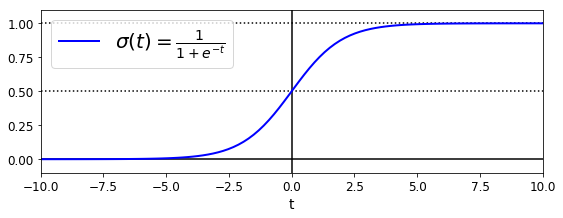

In [0]:
# plot logistic function
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Once the Logistic Regression model has estimated the probability $\hat{p}$ that an instance __x__ belongs to the positive class, it can mae its prediction $\hat{y}$ easily:

$\hat{y} = \begin{cases} 0 & \text{if } \hat{p} < 0.5 \\ 1 & \text{if } \hat{p} \ge 0.5\end{cases}$

Note, if the *logit* score *t* is positive the model predicts 1 and when *t* is negative the model predicts 0.

## Training and Cost Function

The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0).

Cost function of a single training instance:

$c(\theta) = \begin{cases} -log(\hat{p}) & \text{if } y = 1 \\ -log(1 - \hat{p}) & \text{if } y = 0\end{cases}$



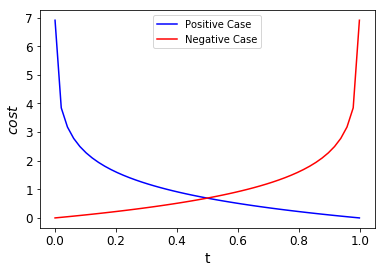

In [0]:
# plot the cost function
t = np.linspace(0.001, .999)
pos = -np.log(t)
neg = -np.log(1-t)

plt.plot(t, pos, 'b-', label = 'Positive Case')
plt.plot(t, neg, 'r-', label = 'Negative Case')
plt.xlabel('t')
plt.ylabel('$cost$')
plt.legend()
plt.show()

For the positive case: 
- the cost will be high when the logit expression is close to 0  
- the cost will be low when the logit expression is close to 1

For the negative case:
- the cost will be high when the logit expression is close to 1
- the cost will be low when the logit expression is close to 0

The average cost over all training instances can be written in a single expression called the *log loss*:

$J(\theta) = - \frac{1}{m} \sum_{i=1}^m [y^i log(\hat{p}^i) + (1-y^i)log(1-\hat{p}^i)]$

Unfortunately, there is no closed-form equation to compute the value of $\theta$ that minimizes this cost function like the Normal Equation.

The good news is that the function is convex so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum.

The partial derivatives of the cost function with regard to the $j^{th}$ model parameter $\theta_j$:

$\frac{\delta}{\delta \theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m (\sigma(\theta^T x^i) - y^i)x_j^i$

For each instance, it computes the prediction error and multiplies it by the $j^{th}$ feature value, and then it computes the average over all training instances.

Once you have the gradient vector containing all the partial derivatives, you can use it in the Batch Gradient Descent algorithm.  For Stochastic GD, you take one instance at a time, and for Mini-batch GD you use a mini-batch at a time.

## Decision Boundaries

Let's use the iris dataset to illustrate Logistic Regression.

We will build a classifier to detect the *Iris virginica* based only on the petal width feature.

First, let's load the data:

In [0]:
from sklearn import datasets

# load Iris dataset
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [0]:
# extract petal width features and label
X = iris['data'][:, 3:]
# 1 if Iris virginica, else 0
y = (iris['target'] == 2).astype(np.int)

In [0]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression constructor
log_reg = LogisticRegression(solver = 'lbfgs')

# fit model to our data
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's look at the model's estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm:

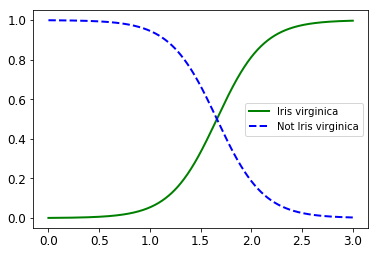

In [0]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend();

In between the two extremes at 1.4 cm to 2.0 cm, the classifer is unsure.  There is a decision boundary at 1.6 cm where both probabilities are around 50%.  It will still predict the flower is an *Iris virginica* even if it is not very confident.

In [0]:
log_reg.predict([[1.66], [1.67]])

array([0, 1])

Logistic Regression models can also be regularized using $\ell_1$ or $\ell_2$ penalties.  Scikit-Learn actually adds an $\ell_2$ penalty by default.

## Softmax Regression

In Linear Regression, multiple binary classifiers were trained.  However, a Logistic Regression model can be generalized to support multiple classes directly.  This is called *Softmas Regression* or *Multinomial Logistic Regression*.

When given an instance __x__, the Softmax Regression model first computes a score $s_k(x)$ for each class *k*, then estimates the probability of each class by applying the *softmax function (normalized exponential)* to the scores.

Softmax score for class k:

$s_k(x) = x^T \theta^k$

Once we have computed the score of every class for the instance __x__, we can estimate the probability $\hat{p}_k$ that the instance belongs to class *k* by running the scores through the softmax function.

The function computes the exponential of every score, then normalizes them by dividing the sum of all the exponentials.

Softmax function:

$\hat{p}_k = \sigma (s(x))_k = \frac{exp(s_k(x))}{\sum_{j=1}^K exp(s_j(x))}$

In this equation:
- *K* is the number of classes
- s(__x__) is a vector containing the scores of each class for the instance __x__
- $\sigma (s(x))_k$ is the estimated probability that the instance __x__ belongs to class *k*

The Softmax Regression classifier predicts the class with the highest estimated probability (the class with the highest score).

Softmax Regression classifier prediction:

$\hat{y} = \underset{k}{\text{argmax}} \, \sigma (s(x))_k = \underset{k}{\text{argmax}} \, s_k(x) = \underset{k}{\text{argmax}} \, ((\theta^k)^Tx)$

In this equation:
- *argmax* returns the value of a variable that maximiezes a function.

__Note: The Softmax Regression classifier can only predict one class at a time.  i.e., it cannot be used to recognize multiple people in one picture.__

Minimizing the cost function called the *cross entropy* should lead to this objective since it penalizes the model when it estimates a low probability for a target class.

Cross entropy cost function:

$J(\Theta) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K y_k^i \log(\hat{p}_k^i)$

In this equation:
- $y_k^i$ is the target probability that the $i^{th}$ instance belongs to class *k*.  In general, it is either equal to 1 or 0.

The gradient vector of this cost function with regard to $\theta^k$ is:

$\triangledown_{\theta^k} J(\Theta) = \frac{1}{m} \sum_{i=1}^m(\hat{p}_k^i - y_k^i)x^i$

Now we can compute the gradient vector for every class, then use Gradient Descent to find the parameter matrix $\Theta$ that minimizes the cost function.

We can use Scikit-Learn's `LogisticRegression` function and set the `multi_class` hyperparameter to "`multinomial`" to switch it to Softmax Regression.  We will also specify a solver that supports Softmax Regression such as "`lbfgs`".  It also applies a $\ell_2$ regularization by default which we can control by using the hyperparameter `C`:

In [0]:
X = iris['data'][:, (2, 3)]
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
softmax_reg.predict([[5, 2]])

array([2])

In [0]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

When the model sees an iris with petals 5 cm long and 2 cm wide, it predicts it is an *Iris virginica* (class 2) with a 94.2% probability.

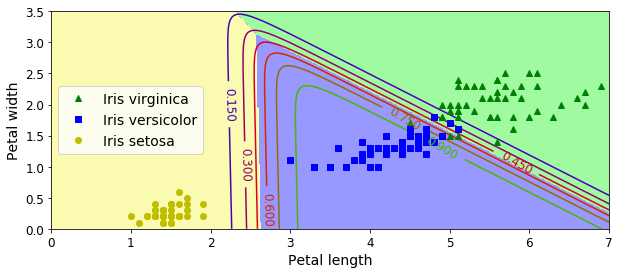

In [0]:
# plot decision boundaries
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()